In [14]:
import numpy as np
import cv2
from tqdm import tqdm
import util
import face_alignment
import os
import imutils
%matplotlib inline
from matplotlib import pyplot as plt

data_dir = "../data/tcdtimit4"

image_list = util.get_file_list(os.path.join(data_dir, 'full'))[100:200]

fa_3d = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False, device='cuda')

landmark_dict = {}

for i in tqdm(range(len(image_list))):
    image_name = image_list[i]
    image = cv2.imread(image_name)
    preds = fa_3d.get_landmarks(image)

    assert preds is not None
    left_eye_landmark = preds[0][:, :2][22:27].astype(int)
    right_eye_landmark = preds[0][:, :2][17:22].astype(int)
    
    leftEyeCenter = left_eye_landmark.mean(axis=0).astype(int)
    rightEyeCenter = right_eye_landmark.mean(axis=0).astype(int)
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
    
    desiredRightEyeX = 1.0 - 0.35
    desiredLeftEyeX = 0.35
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEyeX)
    desiredDist *= 256
    scale = desiredDist / dist

    eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2), int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    
    tX = 256 * 0.5
    tY = 256 * 0.35    
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
    
    (w, h) = (256, 256)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)    
    
    preds = fa_3d.get_landmarks(output)
    lip_landmark = preds[0][:, :2][48:].astype(int)
    (x, y, w, h) = cv2.boundingRect(lip_landmark)
    resized_roi = np.zeros((256, 256, 3), dtype=int)
    roi = output[y:y + h, x:x + w]
    roi = imutils.resize(roi, width=256, inter=cv2.INTER_CUBIC)
    h, w, _ = roi.shape
    resized_roi[:h, :, :] = roi
    
    cv2.imwrite("roi_test/orig_image_{}.png".format(i), image)
    cv2.imwrite("roi_test/roi_image_{}.png".format(i), resized_roi)
    cv2.imwrite("roi_test/norm_image_{}.png".format(i), output)

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


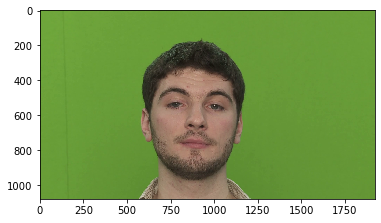

In [10]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')
plt.show()

In [19]:
cv2.boundingRect(landmark_dict['../data/tcdtimit4/full/00001.png'][48:].astype(int))

(801, 728, 167, 59)